In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

In [2]:
def f(x):
    # 3X^2 - 4X + 5
    return 3*(x**2) - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.5)
xs

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])

[100.    83.75  69.    55.75  44.    33.75  25.    17.75  12.     7.75
   5.     3.75   4.     5.75   9.    13.75  20.    27.75  37.    47.75]


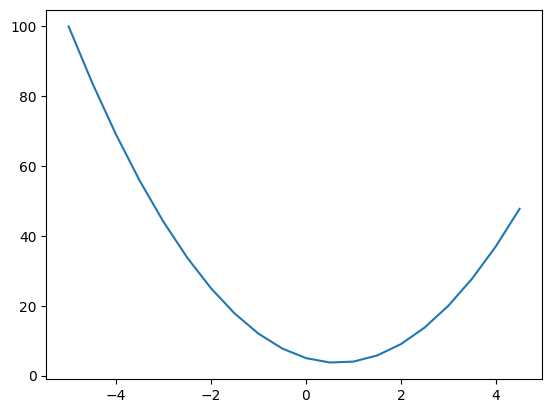

In [5]:
ys = f(xs)
print(ys)
plt.plot(xs,ys)

In [6]:
h = 0.000000000001 
x = 0.800000

def dx(f,x,h):
    """
        f(x + h) - f(x)
        _______________
                h
    """
    result =  (f(x + h) - f(x)) / h
    """if result < 0:
        print("Negative slope.")
    elif result == 0:
        print("No slope. Constant line")
    else:
        print("Positive slope.")"""
    print(f"Slope:{result}")

dx(f, x, h)

Slope:0.7998046669399628


In [7]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

4.0


In [8]:
h = 0.001

a = -20.0
b = 1.0
c = 1.0

d1 = a*b + c

b += h

d2 = a * b + c


print(f"d1: {d1}")
print(f"d2: {d2}")

print(f"slope due to h: { (d1 - d2)/ h}")

d1: -19.0
d2: -19.019999999999996
slope due to h: 19.99999999999602


In [75]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

    # topological sorted
    self.topo_sorted = list()

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  def __radd__(self, other):
        return self.__add__(other)

  def __mul__(self, other):

    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):
    """
      Instead of -> int * Value()
      it checks if Value() * int formula exists
      if yes then we execute that
    """

    return self * other
  
  def __truediv__(self, other):
    return self * other**(-1)
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    print(f"out:{out}, out.grad:{out.grad},self.grad:{self.grad}")
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
        print(f"out:{out}, out.grad:{out.grad},self.grad:{self.grad}")
        
    out._backward = _backward

    return out
  
  def __sub__(self, other):
    return self + (- other)
  
  def __rsub__(self, other):
    return self + (- other)
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), label = 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    """
      Go into each node, and see if it is visited
      For each unvisited node, add in the topo sort
      and each child in previous node of this node
      build the topo.
    """
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.topo_sorted = topo
    # Ah this is the culprit which updates the grad in __pow__
    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()
      
  def exp(self):
    # The value we want to calculate the exp of
    x = self.data
    out = Value(math.exp(x), (self,),label = 'exp')
    def _backward():
       self.grad += out.data * out.grad
    self._backward = _backward

    return out

out:Value(data=4.0), out.grad:0.0,self.grad:0.0
reversed topo:[Value(data=3), Value(data=2.0), Value(data=4.0), Value(data=12.0)]
out:Value(data=4.0), out.grad:3.0,self.grad:12.0


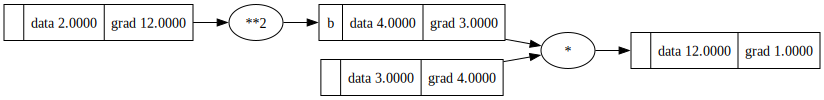

In [27]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes,edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad,), shape ='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [28]:

"""
    A knack at understanding backpropagation:-
        So backpropagation really just means you go back in the node, and
        calculate the d(L)/dV where:
            L   ->  Loss function / final value
            V   ->  Variable (you are considering)

        At each step backward, you are intuitively calculating how much does
        the each variable affects the output variable.
        
        Ex:-
        Say you have to minimize the loss function L, and you are considering variable X.
        
        Assume that d(L)/dX is how much the loss function L is going to change in relation
        to variable X, and in your case say it is very large, which means that your variable
        X is having a very large impact on your end value(L), so you must modify it in tiny amount
        rather than in large numbers.
        
        if d(L)/dX is too large, your aim will be to minimize it right, and see what the effect is.

        So if the gradient of X with respect to y, which is ultimately d(L)/dX is -3.0 (assume)
        That implies that a small change to this weight (say h == 0.001) will bring a negative change
        and hence will reduce the loss function (yay?)

        But if the gradient is +3.0 (assume), then any change (h = 0.001) will bring a positive change,
        which means it will increase the loss value (nah), so you will rather try to bring a negative
        change (h = -0.001) which will act in an opposite manner, and hence reduce the loss value L.
        
"""

'\n    A knack at understanding backpropagation:-\n        So backpropagation really just means you go back in the node, and\n        calculate the d(L)/dV where:\n            L   ->  Loss function / final value\n            V   ->  Variable (you are considering)\n\n        At each step backward, you are intuitively calculating how much does\n        the each variable affects the output variable.\n        \n        Ex:-\n        Say you have to minimize the loss function L, and you are considering variable X.\n        \n        Assume that d(L)/dX is how much the loss function L is going to change in relation\n        to variable X, and in your case say it is very large, which means that your variable\n        X is having a very large impact on your end value(L), so you must modify it in tiny amount\n        rather than in large numbers.\n        \n        if d(L)/dX is too large, your aim will be to minimize it right, and see what the effect is.\n\n        So if the gradient of X with

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----------
# tanh => (e^(2x) - 1)/(e^(2x) + 1)
def Ntanh(x:Value):
    out = Value((math.exp(2 * x.data) - 1)/( math.exp(2 * x.data) + 1), (x,), label = 'tanh')
    e_2x = (2 * x).exp().data
    out2 = Value((e_2x - 1)/(e_2x + 1))
    return out2

o = n.tanh()

# ----------
o.label = 'o'
o.backward()

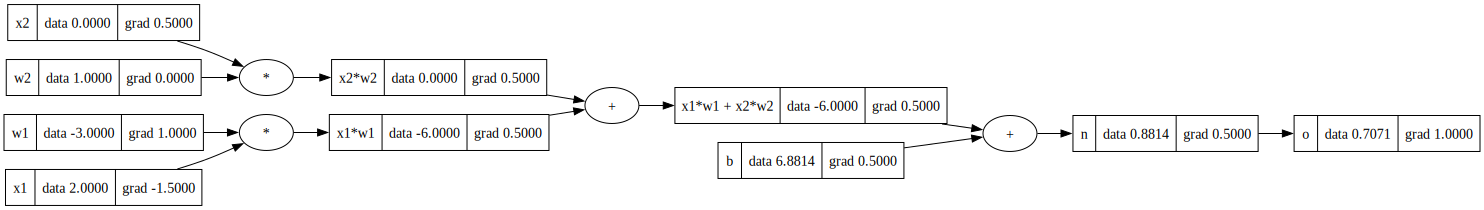

In [30]:
draw_dot(o)

In [41]:
import random
import numpy as np
class Neuron:

    def __init__(self, n_in):
        # Any number between -1 and +1 
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
            act = sum((wi * xi for wi, xi in zip(x, self.w))) + self.b
            out = act.tanh()
            return out
      
    def __repr__(self):
         return f"Neuron(w:{self.w}, b:{self.b})" 

    # return the params of a Neuron
    def parameters(self):
         return self.w + [self.b]
    
class Layer:
    """
    
        X:input     -> Layer
        L1:Layer:-
        Neurons -> n_out neurons

        Layer(3, 3) -> an input array of 3 elements
        and 3 number of neurons at the output

    """
    def __init__(self, n_in, n_out):
          # if the number of out is 2 then of you need
          # 2 neurons
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, input):
        
        outs = [neuron(input) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def __repr__(self):
        return  f"Layer(neurons:{self.neurons})"
    
    def parameters(self):
         return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    """
        MLP(3, [4,4,1])
        This means x:input      -> 3 elements array
        Beyond that you have the first layer:
        L1: 4 Neurons
        L2: 4 Neurons
        L3: 1 Neurons
        each have W,b of (3,1) that is 3 weights and 1 bias
    """
    def __init__(self, n_in, n_out):
            sz = [n_in] + n_out
            self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_out))]
    def __call__(self,  x):
        for layer in self.layers:
             x = layer.__call__(x)
        return x
    
    def parameters(self):
         return [p for layer in self.layers for p in layer.parameters()]
    

In [42]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]



mlp = MLP(3, [4, 4, 1])


In [43]:

for n in range(20):
    y_preds = [mlp(x) for x in xs]
    
    loss = sum((y_truth - y_pred)**2 for y_truth, y_pred in zip(ys, y_preds))

    loss.backward()

    for p in mlp.parameters():
        p.data += - 0.1 * p.grad

    print(n, loss.data)

0 5.328143338579319
1 3.3813754454303333
2 2.3923768822092697
3 6.554552065045565
4 3.9619730187081266
5 0.7348997844460033
6 0.18332176992478702
7 0.14337054501538943
8 0.0011517015399974447
9 1.069491460325039e-05
10 1.5497206884320293e-07
11 3.334256942876852e-09
12 9.896030926355933e-11
13 3.7870587868671135e-12
14 1.772099667868547e-13
15 9.729521906223672e-15
16 6.057720034096174e-16
17 4.1546023626864575e-17
18 3.0635920244816978e-18
19 2.3824688469966117e-19


In [34]:
[mlp(x) for x in xs]


[Value(data=-0.9290708152703347),
 Value(data=-0.9290709782440825),
 Value(data=-0.9290709713505614),
 Value(data=-0.9290708914455582)]